In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
rootpath="../"
print("Loading big matrix...")
big_matrix = pd.read_csv(rootpath + "data/big_matrix.csv")
print("Loading small matrix...")
small_matrix = pd.read_csv(rootpath + "data/small_matrix.csv")

print("Loading social network...")
social_network = pd.read_csv(rootpath + "data/social_network.csv")
social_network["friend_list"] = social_network["friend_list"].map(eval)

print("Loading item features...")
item_feat = pd.read_csv(rootpath + "data/item_categories.csv")
item_feat["feat"] = item_feat["feat"].map(eval)

print("All data loaded.")

Loading big matrix...
Loading small matrix...
Loading social network...
Loading item features...
All data loaded.


In [3]:
small_matrix = small_matrix.dropna()#big_matrix == big_matrix.dropna()

In [4]:
like_threshold = 2

In [5]:
small_matrix_pos = small_matrix[small_matrix["watch_ratio"]>=like_threshold];
small_matrix_pos.shape

(209616, 8)

In [6]:
big_matrix_pos = big_matrix[big_matrix["watch_ratio"]>=like_threshold];
big_matrix_pos.shape

(936568, 8)

In [7]:
item_id_map = {}
user_id_map = {}
userID = 0
itemID = 0
big_pos_list = []
for i in tqdm(range(big_matrix_pos.shape[0])):
    if big_matrix_pos.iloc[i,0] in user_id_map:
        uID = user_id_map[big_matrix_pos.iloc[i,0]]
    else:
        uID = userID
        user_id_map[big_matrix_pos.iloc[i,0]] = uID
        userID += 1
    if big_matrix_pos.iloc[i,1] in item_id_map:
        iID = item_id_map[big_matrix_pos.iloc[i,1]]
    else:
        iID = itemID
        item_id_map[big_matrix_pos.iloc[i,1]] = iID
        itemID += 1  
    big_pos_list.append([uID,iID])
    
small_pos_list = []
for i in tqdm(range(small_matrix_pos.shape[0])):
    if small_matrix_pos.iloc[i,0] in user_id_map:
        uID = user_id_map[small_matrix_pos.iloc[i,0]]
    else:
        continue
    if small_matrix_pos.iloc[i,1] in item_id_map:
        iID = item_id_map[small_matrix_pos.iloc[i,1]]
    else:
        continue 
    small_pos_list.append([uID,iID])

100%|████████████████████████████████████████████████████████████████████████| 209616/209616 [00:22<00:00, 9135.31it/s]


In [8]:
np.save('./features/item_id_map.npy', np.array(item_id_map))
np.save('./features/user_id_map.npy', np.array(user_id_map))

In [9]:
np.save('./sets/small_pos_list.npy', np.array(small_pos_list))
np.save('./sets/big_pos_list.npy', np.array(big_pos_list))

In [10]:
small_pos_dict = {}
for pair in small_pos_list:
    userID, itemID = pair
    if userID not in small_pos_dict:
        small_pos_dict[userID] = []
    small_pos_dict[userID].append(itemID)
big_pos_dict = {}
for pair in big_pos_list:
    userID, itemID = pair
    if userID not in big_pos_dict:
        big_pos_dict[userID] = []
    big_pos_dict[userID].append(itemID)

In [11]:
np.save('./sets/small_pos_dict.npy', np.array(small_pos_dict))
np.save('./sets/big_pos_dict.npy', np.array(big_pos_dict))

In [12]:
for u in small_pos_dict:
    if len(small_pos_dict[u])<2:
        print(u)# able to devide
print("###########")
for u in small_pos_dict:
    if u not in big_pos_dict:
        print(u)

###########


In [13]:
item_feature_dict = {}
i_f_dict = dict(item_feat.feat)
for i in i_f_dict:
    if i in item_id_map:
        item_feature_dict[item_id_map[i]] = i_f_dict[i]
np.save('./features/item_feature_dict.npy', np.array(item_feature_dict))

In [14]:
category_list = []
category_id = {}
for item in item_feature_dict:
    for cat in item_feature_dict[item]:
        if cat not in category_list:
            category_list.append(cat)
            category_id[cat] = cat
np.save('./features/category_id.npy', np.array(category_id))
np.save('./features/category_list.npy', np.array(category_list))

In [15]:
pop_rank = dict(big_matrix_pos['video_id'].value_counts())# original ID 7116 occurs only in small matrix
for i in item_id_map:
    if i not in pop_rank:
        print(i)
        pop_rank[i] = 0
pop_rank_maped = {}
for i in pop_rank:
    if i in item_id_map:
        pop_rank_maped[item_id_map[i]] = pop_rank[i]

item_rank_dict = {} #id:rank
rank = 0
for element in pop_rank_maped:
    item_rank_dict[element] = rank
    rank += 1
np.save('./features/item_rank_dict.npy', np.array(item_rank_dict))

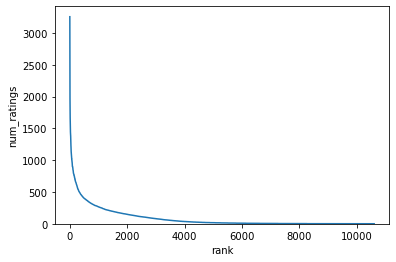

In [16]:
import matplotlib.pyplot as plt
a = pop_rank_maped.values()
plt.plot(a)
plt.ylim(bottom=0.)
#ax.set_xlim(left=0.)
plt.xlabel("rank")
plt.ylabel("num_ratings")
plt.show()

In [17]:
training_list = big_pos_list
validation_list = []
testing_list = []

training_dict = big_pos_dict
validation_dict = {}
testing_dict = {}

for userID in small_pos_dict:
    items = small_pos_dict[userID]
    if len(items) < 2:
        print(userID)
        continue
    if userID not in big_pos_dict:
        continue
    item_num_for_test = max(int(len(items)*0.5), 1)
    test_items = items[-item_num_for_test:]
    items = items[:-item_num_for_test]
    valid_items = items
    
    validation_list += [[userID, itemID] for itemID in list(valid_items)]
    testing_list += [[userID, itemID] for itemID in list(test_items)]
    validation_dict[userID] = valid_items
    testing_dict[userID] = test_items
    
np.save('./sets/training_list.npy', np.array(big_pos_list))
np.save('./sets/validation_list.npy', np.array(validation_list))
np.save('./sets/testing_list.npy', np.array(testing_list))

np.save('./sets/training_dict.npy', np.array(training_dict))
np.save('./sets/validation_dict.npy', np.array(validation_dict))
np.save('./sets/testing_dict.npy', np.array(testing_dict))

In [18]:
user_feature_file = {}
for userID in big_pos_dict:
    user_feature_file[userID] = [['U'+str(userID)]]
    #user_feature_file[userID][0] += ['UF'+feat for feat in user_feature[userID]]
    user_feature_file[userID].append([str(1)]*len(user_feature_file[userID][0]))

item_feature_file = {}
for itemID in tqdm(item_feature_dict):
    item_feature_file[itemID] = [['I'+str(itemID)]]
    item_feature_file[itemID].append(['1'])
    for cate in range(0, len(category_id)):
        if cate in item_feature_dict[itemID]:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(round(1.0/len(item_feature_dict[itemID]), 2)))
        else:
            item_feature_file[itemID][0].append('IC'+str(cate))
            item_feature_file[itemID][1].append(str(0))

np.save('./features/user_feature_file.npy', np.array(user_feature_file))
np.save('./features/item_feature_file.npy', np.array(item_feature_file))

100%|█████████████████████████████████████████████████████████████████████████| 10611/10611 [00:00<00:00, 22384.48it/s]


In [19]:
category_num = len(category_list)
topk_category = 3
user_fml_cat_big = {}
for user in big_pos_dict:
    category_cnt = [0] * category_num
    for item in big_pos_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = sorted_list[-topk_category:]
    user_fml_cat_big[user] = fml_cat

In [20]:
np.save('./features/user_fml_cat.npy', np.array(user_fml_cat_big))

In [21]:
item_cat_vec = {}
for itemID in item_feature_dict:
    item_cat_vec[itemID] = [0] * category_num
    cat_num = len(item_feature_dict[itemID])
    for cat in item_feature_dict[itemID]:
        item_cat_vec[itemID][cat] = 1 / np.sqrt(cat_num)
np.save('./features/item_cat_vec.npy', np.array(item_cat_vec))

In [22]:
category_num = len(category_list)
user_fml_cat_big = {}
for user in training_dict:
    category_cnt = [0] * category_num
    for item in training_dict[user]:
        #print(item_feature_dict[item])
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1/len(item_feature_dict[item])
    pscore = (np.array(category_cnt) / max(category_cnt)) #** 0.5
    user_fml_cat_big[user] = pscore.tolist()
np.save('./features/IPS.npy', np.array(user_fml_cat_big))
np.save('./features/IPS_item_cal.npy', np.array(item_feature_dict))

In [23]:
category_num = len(category_list)
topk_category = 31
user_fml_cat_big = {}
for user in big_pos_dict:
    category_cnt = [0] * category_num
    for item in big_pos_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = sorted_list[-topk_category:]
    user_fml_cat_big[user] = fml_cat

user_fml_cat_small = {}
for user in small_pos_dict:
    category_cnt = [0] * category_num
    for item in small_pos_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = sorted_list[-topk_category:]
    user_fml_cat_small[user] = fml_cat
    
Hit_small = {}
for user in small_pos_dict:
    if user in big_pos_dict:
        Hit_small[user] = 0
        for i in range(topk_category):
            if user_fml_cat_small[user][i] in user_fml_cat_big[user]:
                Hit_small[user] += 1

            
print('Hit small:', round(np.array(list(Hit_small.values())).mean()/topk_category, 5))

Hit small: 1.0


In [24]:
category_num = len(category_list)
topk_category = 10
user_fml_cat_big = {}
for user in big_pos_dict:
    category_cnt = [0] * category_num
    for item in big_pos_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = []
    for i in sorted_list[-topk_category:]:
        if category_cnt[i] != 0:
            fml_cat.append(i)
    user_fml_cat_big[user] = fml_cat

user_fml_cat_small = {}
for user in small_pos_dict:
    category_cnt = [0] * category_num
    for item in small_pos_dict[user]:
        for cat in item_feature_dict[item]:
            category_cnt[cat] += 1
    sorted_list = list(np.argsort(category_cnt))
    fml_cat = []
    for i in sorted_list[-topk_category:]:
        if category_cnt[i] != 0:
            fml_cat.append(i)
    user_fml_cat_small[user] = fml_cat
    
Hit_small = {}
for user in small_pos_dict:
    if user in big_pos_dict:
        Hit_small[user] = 0
        for i in range(len(user_fml_cat_big[user])):
            if user_fml_cat_big[user][i] in user_fml_cat_small[user]:
                Hit_small[user] += 1
        Hit_small[user] /= len(user_fml_cat_small[user])
            
print('Recall small:', round(np.array(list(Hit_small.values())).mean(), 5))

Recall small: 0.56162


In [25]:
len(user_id_map)

7175

In [26]:
len(item_id_map)

10611

In [27]:
len(training_list)

936568

In [28]:
len(testing_list)

104231

In [29]:
len(validation_list)

104928